In [1]:
"""
# [ GRUPO 7 ]
# JOSNICK CHAYÑA BATALLANES
# ANGELO ALDO PEREZ RODRIGUEZ
# KELVIN PAUL PUCHO ZEVALLOS
"""

'\n# [ GRUPO 7 ]\n# JOSNICK CHAYÑA BATALLANES\n# ANGELO ALDO PEREZ RODRIGUEZ\n# KELVIN PAUL PUCHO ZEVALLOS\n'

## Importando Dataset

In [2]:
! git clone https://github.com/kpzaolod6000/INPAINT_AUTOENCODER.git

Cloning into 'INPAINT_AUTOENCODER'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 275 (delta 2), reused 32 (delta 2), pack-reused 243
Receiving objects: 100% (275/275), 29.47 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [3]:
!ls
path = 'INPAINT_AUTOENCODER'

INPAINT_AUTOENCODER  sample_data


## Librerias

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

## Lectura de Datos

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 16

img_transform = transform.Compose([transform.ToTensor(),transform.Resize((540, 540)), transform.Grayscale(num_output_channels=1),transform.Normalize((0.5,),(0.5,))])

train_set = torchvision.datasets.ImageFolder(root= path + "/train", transform=img_transform)
test_set = torchvision.datasets.ImageFolder(root= path + "/test", transform=img_transform)
real_set = torchvision.datasets.ImageFolder(root= path + "/train_cleaned", transform=img_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
real_loader = torch.utils.data.DataLoader(dataset=real_set, batch_size=batch_size, shuffle=False)

cuda:0


In [6]:
print(len(train_set))
print(len(test_set))
print(len(real_set))

144
72
144


In [7]:
print(len(train_loader))
print(len(test_loader))
print(len(real_loader))

9
5
9


## Observar imagenes 

In [8]:
def Show_imgs(imgs, name,  size = 3, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))
  fig = plt.figure(figsize=(rows*size, cols*size))
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      plt.imshow(imgs[i].detach(), cmap = 'gray')
  plt.show()

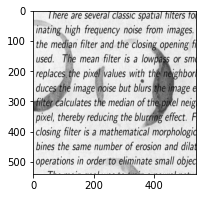

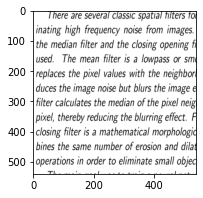

In [9]:
img, label = train_set[143]
Show_imgs(img, str(label))

img, label = real_set[143]
Show_imgs(img, str(label))

## Encoder

In [10]:
class Encoder(nn.Module):
  def __init__(self,n_chans1=64):
    super(Encoder, self).__init__()
    # (1 x 540 x 540)
  
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_chans1, kernel_size=3, stride=1, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
    #self.conv1_dropout = nn.Dropout2d(p=0.5)
    # (64 x 270 x 270)

    self.conv2 = nn.Conv2d(in_channels=n_chans1, out_channels=n_chans1*2, kernel_size=3, stride=1, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1*2)
    #self.conv2_dropout = nn.Dropout2d(p=0.5)
    # (128 x 135 x 135)

  def forward(self, image):
    #print("image",image.shape)
    pool_idxs = []

    #1ra conv
    out = F.relu(self.conv1_batchnorm(self.conv1(image)))
    out, pool_idx = F.max_pool2d(input = out ,kernel_size = 2,return_indices=True)
    #out = self.conv1_dropout(out)
    pool_idxs.append(pool_idx)

    # #2da conv
    out = F.relu(self.conv2_batchnorm(self.conv2(out)))
    out, pool_idx = F.max_pool2d(input = out,kernel_size = 2,return_indices=True)
    #out = self.conv2_dropout(out)
    pool_idxs.append(pool_idx)

    return out, pool_idxs

## Decoder

In [11]:

class Decoder(nn.Module):
  def __init__(self,n_chans1=64):
    super(Decoder, self).__init__()
    self.n_chans1 = n_chans1
    # (128 x 135 x 135)

    self.convTran1 = nn.ConvTranspose2d(in_channels=n_chans1*2,out_channels=n_chans1, kernel_size=3, stride=1, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
    # (64 x 270 x 270)

    self.convTran2 = nn.ConvTranspose2d(in_channels=n_chans1,out_channels=1, kernel_size=3, stride=1, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=1)
    # (1 x 540 x 540)
    
    
  def forward(self, latent, pool_idxs):
    #print(latent.shape)

    #2da convTranpose  
    out = F.max_unpool2d(input = latent, indices = pool_idxs[1],kernel_size = 2)
    out = F.relu(self.convTran1(out))

    #2da convTranpose
    out = F.max_unpool2d(input = out, indices = pool_idxs[0],kernel_size = 2)
    out = F.relu(self.convTran2(out))

    out = torch.tanh(out)
    
    return out

# Autoencoder

In [12]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent, pool_idxs = self.encoder(x)
        #print("encoder")
        x_recon = self.decoder(latent,pool_idxs)
        return x_recon

## Training

In [13]:
def train(model, train_loader,real_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0

      
      for tuplas in zip(train_loader,real_loader):
          
          image_batch_r = tuplas[0][0].to(device)
          real_batch_r = tuplas[1][0].to(device)
          #print(image_batch_r.size())
          
          image_batch_recon = model(image_batch_r)
          #print(image_batch_recon.size())
          loss = loss_fn(image_batch_recon,real_batch_r)
          #print("el loss es",loss)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      
    return train_loss_avg

In [15]:
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

loss_result = train(autoencoder,train_loader,real_loader,50,loss)

Epoch [1 / 50] average reconstruction error: 0.156179
Epoch [2 / 50] average reconstruction error: 0.068710
Epoch [3 / 50] average reconstruction error: 0.063938
Epoch [4 / 50] average reconstruction error: 0.061489
Epoch [5 / 50] average reconstruction error: 0.059744
Epoch [6 / 50] average reconstruction error: 0.058684
Epoch [7 / 50] average reconstruction error: 0.057749
Epoch [8 / 50] average reconstruction error: 0.057002
Epoch [9 / 50] average reconstruction error: 0.056416
Epoch [10 / 50] average reconstruction error: 0.055932
Epoch [11 / 50] average reconstruction error: 0.055526
Epoch [12 / 50] average reconstruction error: 0.055173
Epoch [13 / 50] average reconstruction error: 0.054866
Epoch [14 / 50] average reconstruction error: 0.054599
Epoch [15 / 50] average reconstruction error: 0.054369
Epoch [16 / 50] average reconstruction error: 0.054160
Epoch [17 / 50] average reconstruction error: 0.053961
Epoch [18 / 50] average reconstruction error: 0.053773
Epoch [19 / 50] ave

## Loss Function

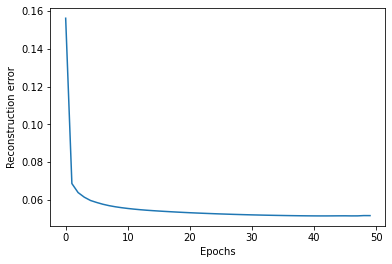

In [16]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

## Resultados

### Funcion para Mostrar imagenes

In [17]:
def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

### Resultados de las pruebas

imagen con ruido


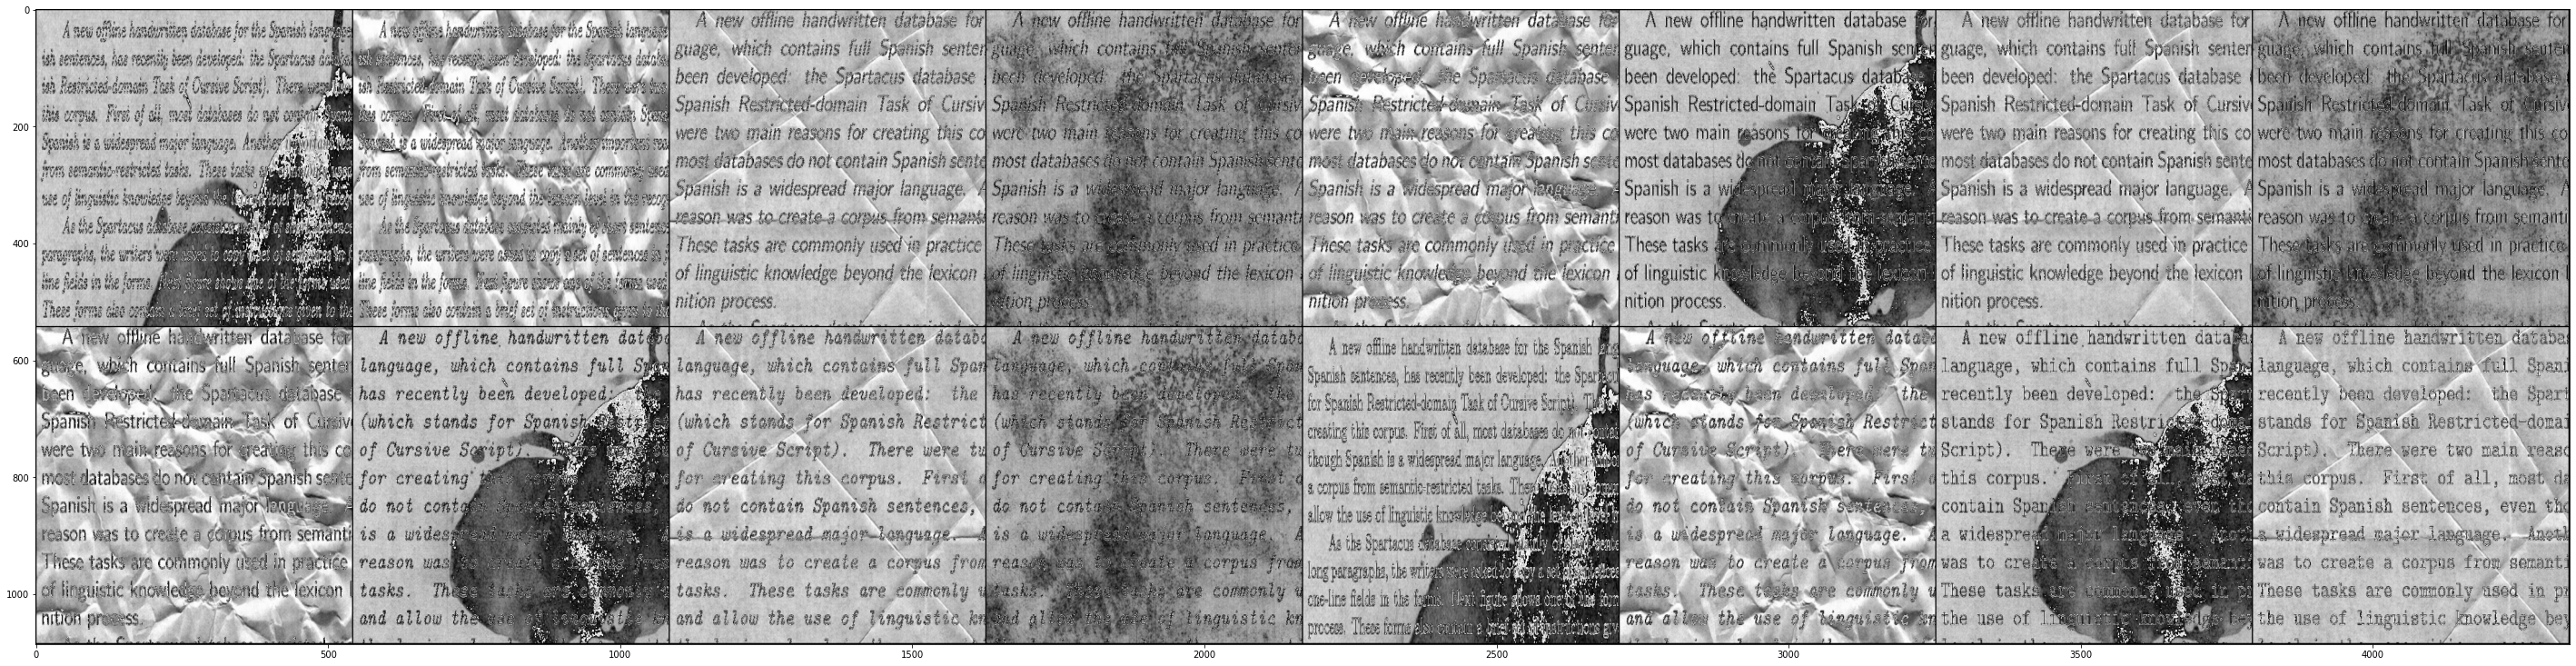

imagen Estimada


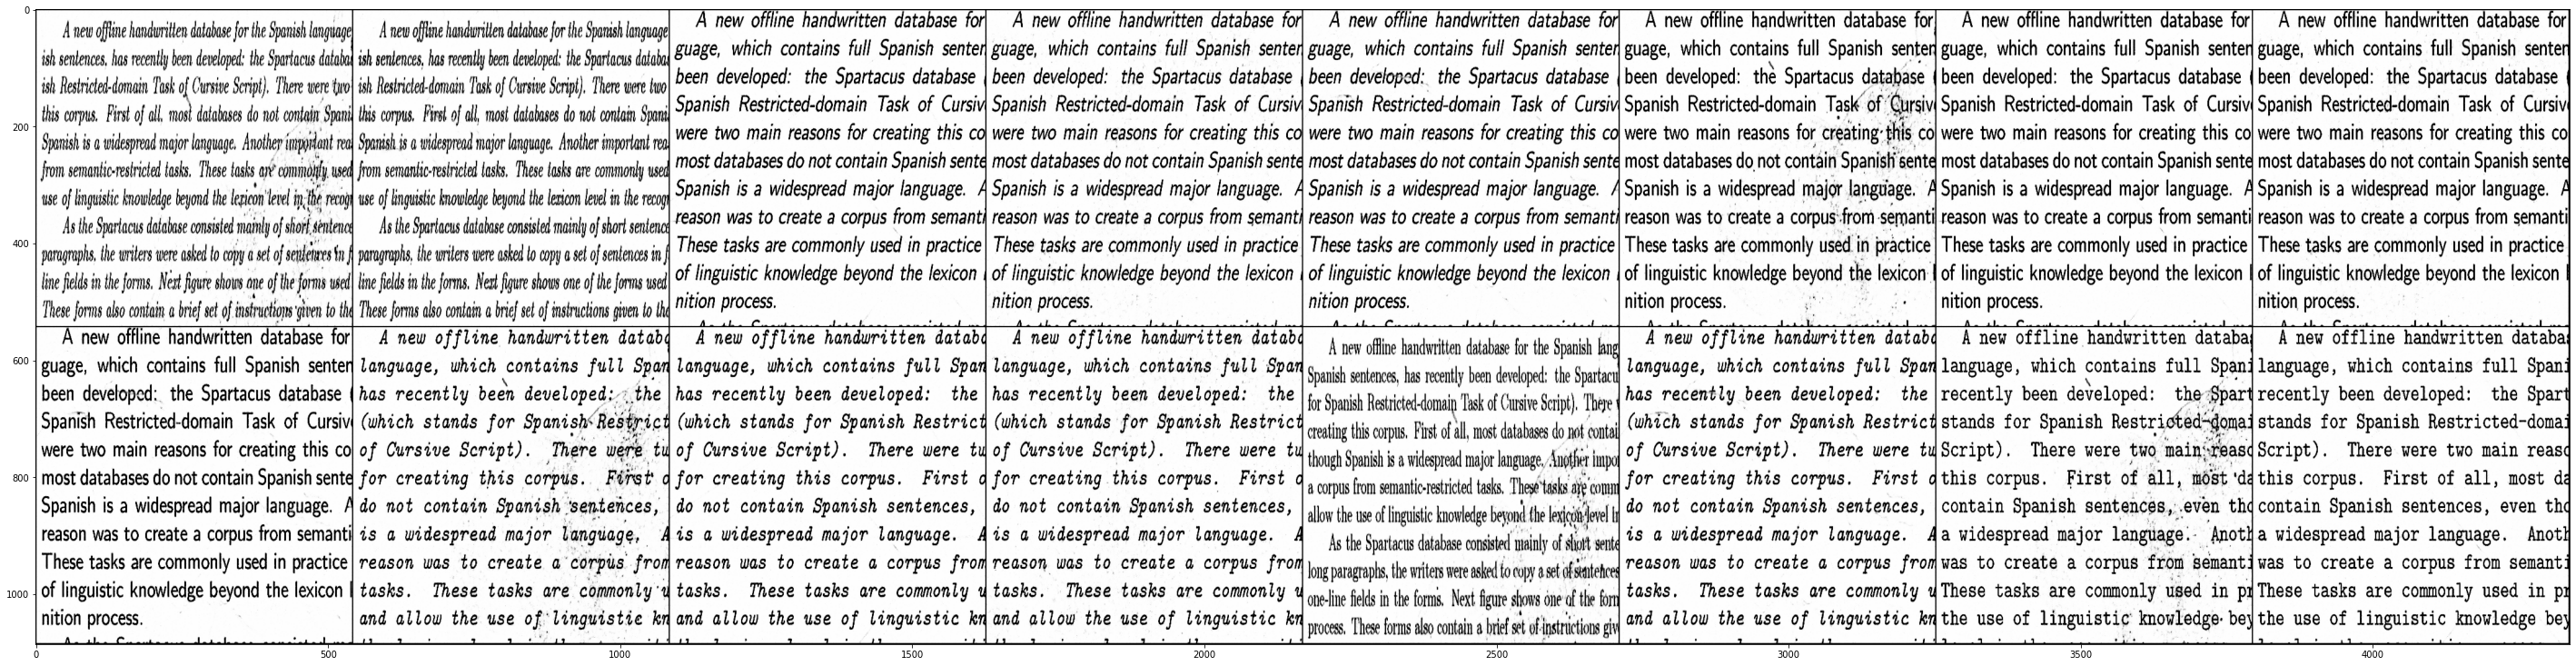

In [18]:
image,label = iter(test_loader).next()

image_r = image.to(device)

z,pool = autoencoder.encoder(image_r)
z = z.to(device)
#pool = pool.to(device)
decodificado = autoencoder.decoder(z,pool)
decodificado = decodificado.to(device)

print("imagen con ruido")
fig, ax = plt.subplots(figsize = (50,50))
Show_Weight(image[0:16])
plt.show()

print("imagen Estimada")
fig, ax = plt.subplots(figsize=(50, 50))
Show_Weight(decodificado[0:16])
plt.show()
